In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, make_scorer, roc_auc_score
import time

# warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import dataset

train = pd.read_csv('~/Documents/ML-USU-SP21-main/personal/water-portability-classification/Train.csv')
test = pd.read_csv('~/Documents/ML-USU-SP21-main/personal/water-portability-classification/Test.csv')

In [3]:
train.shape,test.shape

((2260, 11), (1016, 10))

In [4]:
train

,region_area_,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,region_area_1,3.716080,180.196811,18630.362669,6.330435,NaN,602.990359,15.285013,56.444076,4.500656,0
1,region_area_100,4.270716,217.611599,24405.555346,7.086700,297.951852,359.623910,13.583526,54.589840,3.763906,0
2,region_area_1000,6.648849,232.462013,30733.808648,5.656462,344.670335,267.809179,17.863444,35.411181,4.827527,0
3,region_area_1001,NaN,261.753637,21174.713291,7.314074,NaN,582.848407,15.215849,90.367455,4.217553,0
4,region_area_1002,9.323584,263.484560,15751.480111,5.196259,297.593625,409.878704,10.727265,74.669285,3.006650,0
...,...,...,...,...,...,...,...,...,...,...,...
2255,region_area_993,8.347949,281.976992,13533.534844,7.318793,314.416241,537.485871,18.768901,58.167866,4.217861,0
2256,region_area_994,6.615982,245.754527,20919.356245,5.831559,NaN,393.227057,9.789376,41.452775,4.635709,0
2257,region_area_996,6.836225,217.516852,24293.477473,6.556425,333.626695,400.909955,16.111991,87.216925,3.666614,0
2258,region_area_997,6.385471,282.262348,26757.222810,8.469546,NaN,432.172701,16.668116,73.375640,4.681717,0


In [5]:
ntrain = train.shape[0]

In [6]:
# combine data
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.shape

(3276, 11)

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region_area_     3276 non-null   object 
 1   ph               2785 non-null   float64
 2   Hardness         3276 non-null   float64
 3   Solids           3276 non-null   float64
 4   Chloramines      3276 non-null   float64
 5   Sulfate          2495 non-null   float64
 6   Conductivity     3276 non-null   float64
 7   Organic_carbon   3276 non-null   float64
 8   Trihalomethanes  3114 non-null   float64
 9   Turbidity        3276 non-null   float64
 10  Potability       2260 non-null   float64
dtypes: float64(10), object(1)
memory usage: 281.7+ KB


In [8]:
all_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ph,2785.0,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
Hardness,3276.0,247.143387,32.879761,98.205891,227.624429,247.741518,267.441347,373.897891
Solids,3276.0,22014.397337,8768.570828,321.247422,15666.995108,20928.138417,27333.066938,61227.500818
Chloramines,3276.0,6.817466,1.583085,0.047189,5.822610,6.825488,7.810076,12.822189
Sulfate,2495.0,334.520890,41.416840,129.745113,308.444611,333.818659,360.695284,481.775755
Conductivity,3276.0,436.310111,80.824064,191.588754,375.839414,431.989968,491.897304,763.447620
Organic_carbon,3276.0,14.389970,3.308162,2.305000,12.170801,14.323338,16.662652,28.405000
Trihalomethanes,3114.0,66.511293,16.175008,0.853000,55.959536,66.737485,77.452473,124.115000
Turbidity,3276.0,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,2260.0,0.388496,0.487516,0.000000,0.000000,0.000000,1.000000,1.000000


In [9]:
all_data.head()

,region_area_,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,region_area_1,3.716080,180.196811,18630.362669,6.330435,NaN,602.990359,15.285013,56.444076,4.500656,0.0
1,region_area_100,4.270716,217.611599,24405.555346,7.086700,297.951852,359.623910,13.583526,54.589840,3.763906,0.0
2,region_area_1000,6.648849,232.462013,30733.808648,5.656462,344.670335,267.809179,17.863444,35.411181,4.827527,0.0
3,region_area_1001,NaN,261.753637,21174.713291,7.314074,NaN,582.848407,15.215849,90.367455,4.217553,0.0
4,region_area_1002,9.323584,263.484560,15751.480111,5.196259,297.593625,409.878704,10.727265,74.669285,3.006650,0.0


In [10]:
all_data.isnull().sum()

region_area_          0
ph                  491
Hardness              0
Solids                0
Chloramines           0
Sulfate             781
Conductivity          0
Organic_carbon        0
Trihalomethanes     162
Turbidity             0
Potability         1016
dtype: int64

In [11]:
# missing data
# ph - mean, median
# sulfate - mean, median
# trihalomethanes - mean, median
# potability - mode

median1 = all_data['ph'].mode().values[0]
median2 = all_data['Sulfate'].mode().values[0]
median3 = all_data['Trihalomethanes'].mode().values[0]
mode = all_data['Potability'].mode().values[0]

all_data['ph'] = all_data['ph'].replace(np.NaN, median1)
all_data['Sulfate'] = all_data['Sulfate'].replace(np.NaN, median2)
all_data['Trihalomethanes'] = all_data['Trihalomethanes'].replace(np.NaN, median3)
all_data['Potability'] = all_data['Potability'].replace(np.NaN, mode).astype(int)

# mode

In [12]:
all_data

,region_area_,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,region_area_1,3.716080,180.196811,18630.362669,6.330435,129.745113,602.990359,15.285013,56.444076,4.500656,0
1,region_area_100,4.270716,217.611599,24405.555346,7.086700,297.951852,359.623910,13.583526,54.589840,3.763906,0
2,region_area_1000,6.648849,232.462013,30733.808648,5.656462,344.670335,267.809179,17.863444,35.411181,4.827527,0
3,region_area_1001,0.000000,261.753637,21174.713291,7.314074,129.745113,582.848407,15.215849,90.367455,4.217553,0
4,region_area_1002,9.323584,263.484560,15751.480111,5.196259,297.593625,409.878704,10.727265,74.669285,3.006650,0
...,...,...,...,...,...,...,...,...,...,...,...
3271,region_area_986,7.651294,251.490942,11699.438360,6.343462,350.000558,430.933362,18.968817,53.023851,3.258042,0
3272,region_area_987,4.771491,251.147966,48002.389407,8.860429,341.055289,321.032835,18.873328,63.779155,3.936973,0
3273,region_area_989,5.392058,248.791056,19900.712648,7.538415,349.697038,429.918956,14.721509,80.683252,2.978925,0
3274,region_area_995,8.312380,254.518438,8727.552160,7.151492,129.745113,553.497988,15.575400,81.623682,2.988093,0


In [13]:
all_data.isnull().sum()

region_area_       0
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

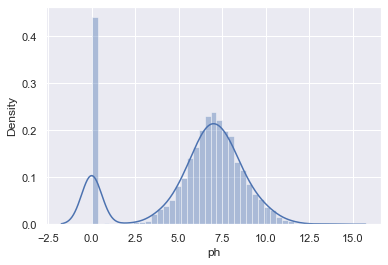

In [14]:
sns.distplot(all_data.ph)
plt.show()

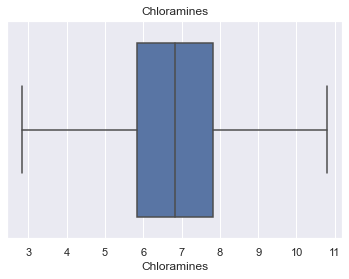

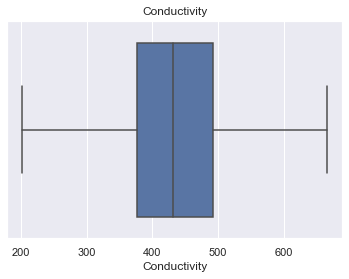

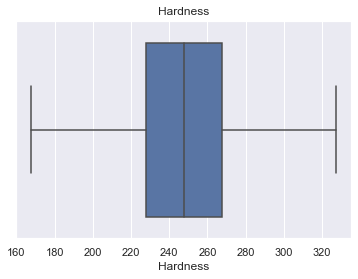

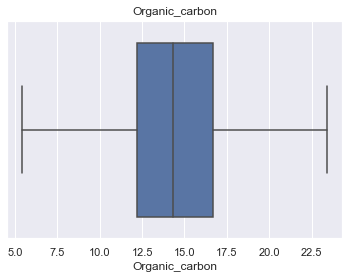

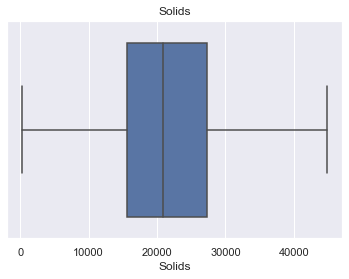

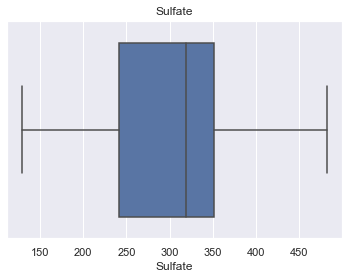

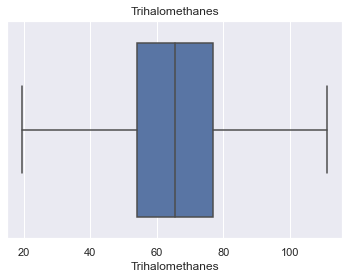

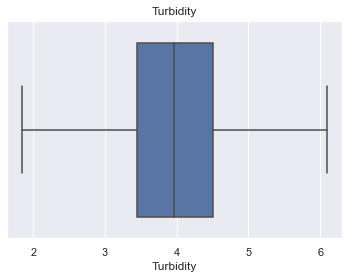

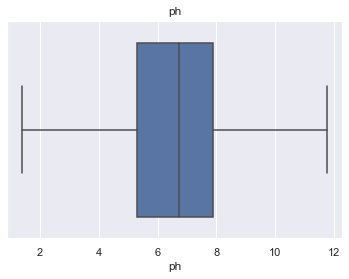

In [15]:
# outliers treatment
def remove_outlier(col):
    sorted(col)
    q1, q3 = col.quantile([0.25,0.75])
    iqr = q3 -q1
    lower_range = q1 - (1.5 * iqr)
    upper_range = q3 + (1.5 * iqr)  
    return lower_range, upper_range

for x in list(all_data.columns.difference(['region_area_','Potability','hard_p'])):
    lower_ph, upper_ph = remove_outlier(all_data[x])
    all_data[x] = np.where(all_data[x]<lower_ph,lower_ph,all_data[x])
    all_data[x] = np.where(all_data[x]>upper_ph,upper_ph,all_data[x])

for col in list(all_data.columns.difference(['region_area_','Potability'])):
    sns.boxplot(all_data[col])
    plt.title(col)
    plt.show()

In [16]:
all_data['Turbidity'].value_counts()

1.848797    10
6.091233     9
4.263180     1
3.762223     1
2.395002     1
            ..
3.189942     1
4.593787     1
5.612296     1
2.884819     1
3.285077     1
Name: Turbidity, Length: 3259, dtype: int64

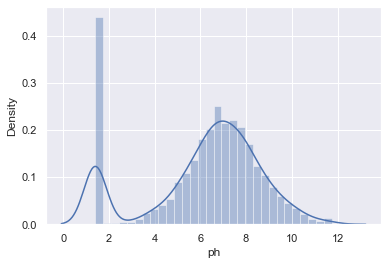

In [17]:
sns.distplot(all_data.ph)
plt.show()

In [32]:
train['Potability'].value_counts()

0    1382
1     878
Name: Potability, dtype: int64

<AxesSubplot:xlabel='Potability', ylabel='count'>

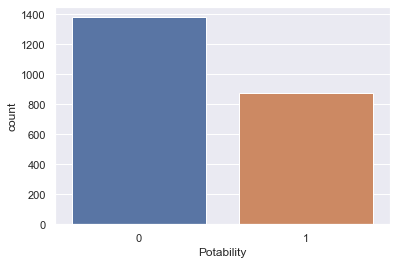

In [33]:
sns.countplot(train.Potability, data = train)

In [78]:
all_data['ph_port'] = np.where((all_data['ph']>=6.5) & (all_data['ph']<=8.5), 1, 0)
# all_data['sulf_port'] = np.where(all_data['Sulfate']<250, 1, 0)
all_data['hard_port'] = np.where((all_data['Hardness']>=120) & (all_data['Hardness']<=180), 1, 0)

In [79]:
# split data
train_ds = all_data[:ntrain]
test_ds =  all_data[ntrain:]

train_ds.shape,test_ds.shape

((2260, 14), (1016, 14))

In [80]:
train_ds[train_ds['Potability']==1]

,region_area_,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,ph_port,sulf_port,hard_port
52,region_area_1070,7.080795,243.028053,21762.918956,6.954828,332.394772,407.367826,18.366213,46.096624,4.344805,1,1,0,0
53,region_area_1072,7.080795,223.505323,28894.781781,3.946106,267.903073,569.734340,21.445849,51.389712,2.959750,1,1,0,0
54,region_area_1073,7.203439,219.219249,22826.789508,5.978439,272.637158,447.475863,16.515654,64.620923,6.091233,1,1,0,0
55,region_area_1074,6.150488,291.662313,6342.807653,9.305085,401.067547,364.497526,12.445384,83.353661,3.551656,1,0,0,0
56,region_area_1075,7.080795,276.732983,9660.963113,8.522844,398.669353,325.855909,16.821557,26.734225,3.959294,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120,region_area_815,7.080795,253.249053,23828.512492,5.226874,401.067547,424.722655,13.902656,59.636664,5.266368,1,1,0,0
2121,region_area_816,5.452215,250.002358,14447.117200,7.384380,299.063531,479.236951,14.125507,95.421239,5.190534,1,0,0,0
2122,region_area_817,7.080795,266.740470,21852.742755,7.152704,284.500937,374.806095,11.488210,76.653803,5.076362,1,1,0,0
2123,region_area_818,5.433466,228.602193,31422.036444,4.279323,347.842467,500.389674,16.171439,58.531699,2.871196,1,0,0,0


In [53]:
train_ds[train_ds['Potability']==0]

,region_area_,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,ph_port,sulf_port,hard_port
0,region_area_1,3.889107,180.196811,18630.362669,6.330435,334.520890,602.990359,15.285013,56.444076,4.500656,0,0,0,0
1,region_area_100,4.270716,217.611599,24405.555346,7.086700,297.951852,359.623910,13.583526,54.589840,3.763906,0,0,0,0
2,region_area_1000,6.648849,232.462013,30733.808648,5.656462,344.670335,267.809179,17.863444,35.411181,4.827527,0,1,0,0
3,region_area_1001,7.080795,261.753637,21174.713291,7.314074,334.520890,582.848407,15.215849,90.367455,4.217553,0,1,0,0
4,region_area_1002,9.323584,263.484560,15751.480111,5.196259,297.593625,409.878704,10.727265,74.669285,3.006650,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2255,region_area_993,8.347949,281.976992,13533.534844,7.318793,314.416241,537.485871,18.768901,58.167866,4.217861,0,1,0,0
2256,region_area_994,6.615982,245.754527,20919.356245,5.831559,334.520890,393.227057,9.789376,41.452775,4.635709,0,1,0,0
2257,region_area_996,6.836225,217.516852,24293.477473,6.556425,333.626695,400.909955,16.111991,87.216925,3.666614,0,1,0,0
2258,region_area_997,6.385471,282.262348,26757.222810,8.469546,334.520890,432.172701,16.668116,73.375640,4.681717,0,0,0,0


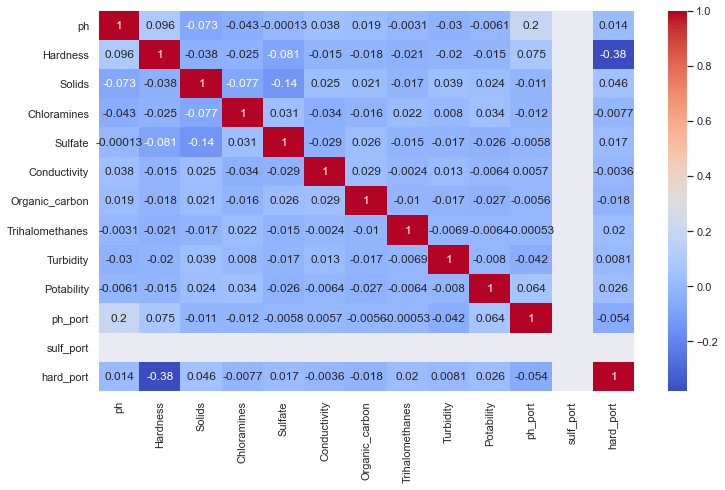

In [54]:
plt.figure(figsize=(12,7))
sns.heatmap(train_ds.corr(), cmap='coolwarm', annot=True)
plt.show()

In [55]:
main_cols = all_data.columns.difference(['region_area_','Potability'])

X = train_ds[main_cols]
y = train_ds['Potability']

# pd.crosstab(y['Potability'], y['Potability'], normalize='all') * 100

from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# pd.crosstab(y['Potability'], y['Potability'], normalize='all') * 100
seed = 42
# Split data into train and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y.values,test_size=0.25, random_state=seed)

LIGHTGBM CLASSIFIER

In [56]:
# # pipeline for lightgbm
# pipe = Pipeline([
#     ('scale' , StandardScaler()),
#     ('model' , LGBMClassifier(objective= 'binary', class_weight='balanced'))
# ])
# pipe.get_params()

# hyperparameter tunning, cross validation, and evaluation metrics with gridsearch

# stratefies kfold
inner_kfold = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)

# lightgbm classifier
# model = GridSearchCV(
#     estimator = pipe,
#     param_grid = {'model__num_leaves' : [60, 70, 80, 90, 100],
#                   'model__min_child_samples' : [10, 15, 20, 22],
#                   'model__max_depth' : [-1, 2, 5, 10],
#                   'model__learning_rate' : [0.05, 0.1, 0.2],
#                   'model__reg_alpha' : [0.0, 0.01, 0.03]},
#     scoring = {'roc_auc' : make_scorer(roc_auc_score), 'accuracy' : make_scorer(accuracy_score), 'f1_score' : make_scorer(f1_score)},
#     refit = 'f1_score',
#     cv = inner_kfold,
#     n_jobs = -1
# )

RANDOM FOREST

In [57]:
# pipeline for random forest
pipe = Pipeline([
    ('scale' , StandardScaler()),
    ('model' , RandomForestClassifier(n_estimators = 100, random_state = 1000, class_weight='balanced_subsample'))
])
# pipe.get_params()

# random forest
model = GridSearchCV(
    estimator = pipe,
    param_grid = {'model__criterion' : ['entropy', 'gini'],
                  'model__max_depth' : [10,20,30],
                  'model__max_features' : ['log2', 'sqrt', 'auto']},
    scoring = {'accuracy' : make_scorer(accuracy_score), 'f1_score' : make_scorer(f1_score)},
    refit = 'f1_score',
    cv = inner_kfold,
)

CATBOOST

In [58]:
# pipeline for catboost
# pipe = Pipeline([
#     ('scale' , StandardScaler()),
#     ('model' , LGBMClassifier())
# ])
# pipe.get_params()

# catboost
# model = GridSearchCV(
#     estimator = pipe,
#     param_grid = {},
#     scoring = {'roc_auc' : make_scorer(roc_auc_score), 'accuracy' : make_scorer(accuracy_score), 'f1_score' : make_scorer(f1_score)},
#     refit = 'f1_score',
#     cv = inner_kfold,
#     n_jobs = -1
# )

XGBOOST

In [59]:
# pipeline for xgboost
# pipe = Pipeline([
#     ('scale' , StandardScaler()),
#     ('model' , LGBMClassifier(objective= 'binary', class_weight='balanced'))
# ])
# pipe.get_params()

# xgboost
# model = GridSearchCV(
#     estimator = pipe,
#     param_grid = {},
#     scoring = {'roc_auc' : make_scorer(roc_auc_score), 'accuracy' : make_scorer(accuracy_score), 'f1_score' : make_scorer(f1_score)},
#     refit = 'f1_score',
#     cv = inner_kfold,
#     n_jobs = -1
# )

In [60]:
# training and prediction on train dataset
start = time.time()
model.fit(X_train,y_train)
end = time.time()
diff = end - start
print('execution time : ', round(diff, 2), 'seconds')

execution time :  73.72 seconds


In [61]:
model.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=30, max_features='log2',
                                        random_state=1000))])

In [62]:
# model.best_params_

In [63]:
ypred = model.predict(X_valid)
# ypred

In [64]:
f1_score(y_valid, ypred), accuracy_score(y_valid, ypred)

(0.6726457399103138, 0.683068017366136)

In [65]:
# score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = inner_kfold, scoring = 'roc_auc')
# score

In [66]:
# features = list(X_train.columns)
# importance = model.feature_importances_

In [67]:
# FIM = pd.DataFrame({'Features': features , 'Feature_importance':importance})
# FIM = FIM.sort_values(by=['Feature_importance'])
# FIM

In [68]:
# plt.figure(figsize=(10,6))
# plt.title('Feature Importance')
# sns.barplot(y='Features', x='Feature_importance', data=FIM)
# plt.show()

In [69]:
# prediction on test dataset
X_test_ds = test_ds[main_cols]

# y_pred = model.predict(X_test_ds)
y_pred = model.predict_proba(X_test_ds)
y_pred = np.where(y_pred > 0.4, 1, 0)
y_pred = y_pred[:,1]
# y_pred = pd.Series(y_pred)
# y_pred.value_counts()
y_pred

array([0, 1, 0, ..., 1, 0, 0])

In [70]:
data = pd.DataFrame(y_pred, index = test_ds['region_area_'], columns = ['Potability'])
data.to_csv('Potability.csv')

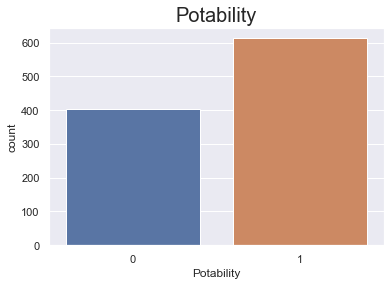

In [172]:
all_ = pd.read_csv('~/Documents/ML-USU-SP21-main/personal/water-portability-classification/Potability.csv')
sns.countplot(all_.Potability, data=all_)
plt.title('Potability', fontdict={'size':20});
# sns.countplot(all_data.Potability, data = all_data)

In [173]:
all_.Potability.value_counts()

1    613
0    403
Name: Potability, dtype: int64